In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import torch
import os
import h5py
import re

In [2]:
# font = {'family' : 'normal',
#         'size'   : 14}
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Palatio']
rcParams['text.usetex'] = True

fontsize = 18 #adjust

#plt.rc('font', **font)
figure_path = "./figures/"

blue = (31,119,180)
blue = np.array([x/255 for x in blue])

orange = (255,127,14)
orange = np.array([x/255 for x in orange])

green = (44,160,44)
green = np.array([x/255 for x in green])

red = (214,39,40)
red = np.array([x/255 for x in red])

purple = (148,103,189)
purple = np.array([x/255 for x in purple])

## HCAS whole input domain

In [3]:
logs_dir = "./logs_precomputed"
setting = "HCAS_p0_t0_100_m20_pr_035_wid-1_jp1_slice_global"
path = os.path.join(logs_dir,setting+"_ranges.pkl")
path_log = os.path.join(logs_dir,setting+".txt")

cert_ranges = pkl.load(open(path, "rb"))

In [4]:
# Slice ranges
x_min = -10000
x_max = 30000
y_min = -10000
y_max = 30000
psi_min = -180
psi_max = -0

In [5]:
tot_volume = (x_max-x_min)/112000*(y_max-y_min)/112000*(psi_max-psi_min)/360
cert_volume=0
for lb, ub, label in cert_ranges:
    volume = (ub[0]-lb[0])*(ub[1]-lb[1])*(ub[2]-lb[2])/tot_volume
    cert_volume += volume
print(f"The certified portion of the considered volume is {cert_volume:.4f}")

The certified portion of the considered volume is 0.8283


In [6]:
with open(path_log,"r") as f:
    lines = f.readlines()

times = []
for line in lines:
    if "time" in line:
        s = float(re.match(".*time: ([0-9,\.]*)$", line).group(1))
        times.append(s)

print(f"Certification took a total of {sum(times)/3600.:.4f} hours")

Certification took a total of 15.4878 hours


## HCAS visualization slice

In [7]:
logs_dir = "./logs"
setting = "HCAS_p0_t0_100_m20_pr_035_wid10_jp1_slice_long_superfine"
path = os.path.join(logs_dir,setting+"_ranges.pkl")
path_log = os.path.join(logs_dir,setting+".txt")

cert_ranges = pkl.load(open(path, "rb"))

In [8]:
# Slice ranges
x_min = -5000
x_max = 25000
y_min = -10000
y_max = 20000
psi_min = -90.5
psi_max = -89.5

In [9]:
tot_volume = (x_max-x_min)/112000*(y_max-y_min)/112000*(psi_max-psi_min)/360
cert_volume=0
for lb, ub, label in cert_ranges:
    volume = (ub[0]-lb[0])*(ub[1]-lb[1])*(ub[2]-lb[2])/tot_volume
    cert_volume += volume
print(f"The certified portion of the considered volume is {cert_volume:.4f}")

The certified portion of the considered volume is 0.9852


In [10]:
with open(path_log,"r") as f:
    lines = f.readlines()

times = []
for line in lines:
    if "time" in line:
        s = float(re.match(".*time: ([0-9,\.]*)$", line).group(1))
        times.append(s)

print(f"Certification took a total of {sum(times)/3600.:.4f} hours")

Certification took a total of 29.6575 hours


In [11]:
ver = 6  # Neural network version
table_ver = 6  # Table Version
trainingDataFiles = "./TrainingData/HCAS_rect_TrainingData_v%d_pra%d_tau%02d.h5"  # File format for training data

pra = 0
tau = 0

print("Loading Data for HCAS, pra %02d, Network Version %d" % (pra, ver))
f = h5py.File(trainingDataFiles % (table_ver, pra, tau), 'r')
X_train = np.array(f['X'])
X_train = X_train - X_train.min(0)
assert (X_train.max(0)==1).all()
Q = np.array(f['y'])
means = np.array(f['means'])
ranges = np.array(f['ranges'])[:3]
mins = np.array(f['min_inputs'])
maxes = np.array(f['max_inputs'])
widths = maxes-mins

X_train = X_train *(maxes-mins) + mins
z = Q.argmax(1)

Loading Data for HCAS, pra 00, Network Version 6


In [12]:
idxs = (np.abs(X_train[:,2]+np.pi/2)<0.001).__and__(X_train[:,0]>=x_min).__and__(X_train[:,0]<=x_max).__and__(X_train[:,1]<=y_max).__and__(X_train[:,1]>=y_min)

X_filtered = X_train[idxs]
z_filtered = z[idxs]

In [13]:
# Plot legend
fig, ax = plt.subplots(figsize=(5,1))
for label in range(5):
    if label == 0:  # COC clear of contact
        c = "lightgray"
    elif label == 1:  # Weak Left
        c = 1-(1-green)*0.5
    elif label == 2:  # Strong Left
        c = green*0.8
    elif label == 3:  # Weak Right
        c = 1-(1-blue)*0.5
    elif label == 4:  # Strong Right
        c = blue*0.8
    i=label
    ax.fill([3.5*i,3.5*i,3.5*i+2,3.5*i+2], [1,0,0,1], color=c)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.axis('off')

# fig.savefig(os.path.join(figure_path,"HCAS_leg_slice.eps"), bbox_inches="tight")
# fig.savefig(os.path.join(figure_path,"HCAS_leg_slice.png"), bbox_inches="tight")

(-0.8, 16.8, -0.05, 1.05)

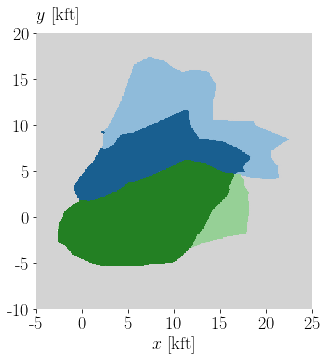

In [14]:
# Plot prediction

fig, ax = plt.subplots(figsize=(5,5))

for lb, ub, label in cert_ranges:
    x = [lb[0], lb[0], ub[0], ub[0], ]
    y = [lb[1], ub[1], ub[1], lb[1], ]

    if label == 0:  # COC clear of contact
        c = "lightgray"
    elif label == 1:  # Weak Left
        c = 1-(1-green)*0.5
    elif label == 3:  # Strong Left
        c = green*0.8
    elif label == 2:  # Weak Right
        c = 1-(1-blue)*0.5
    elif label == 4:  # Strong Right
        c = blue*0.8
    ax.fill(x, y, color=c)
    
ax.set_xlim([(x_min+56000)/112000,(x_max+56000)/112000])
plt.ylabel(r"$y$ [kft]",rotation=0 , fontsize=fontsize,ha="left")
ax.yaxis.set_label_coords(0.0, 1.03)
plt.xlabel(r"$x$ [kft]", fontsize=fontsize)
plt.ylim([(y_min+56000)/112000,(y_max+56000)/112000])
plt.yticks(np.arange((y_min+56000)/112000,(y_max+56000)/112000+0.001,5000/112000),[f"{x:.0f}" for x in np.arange(y_min/1000,y_max/1000+0.001,5)])
plt.xticks(np.arange((x_min+56000)/112000,(x_max+56000)/112000+0.001,5000/112000),[f"{x:.0f}" for x in np.arange(x_min/1000,x_max/1000+0.001,5)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
fig.tight_layout()
ax.set_aspect('equal', 'box')


# fig.savefig(os.path.join(figure_path,"HCAS_cert_slice_nb.eps"), bbox_inches="tight")
# fig.savefig(os.path.join(figure_path,"HCAS_cert_slice_nb.png"), bbox_inches="tight")

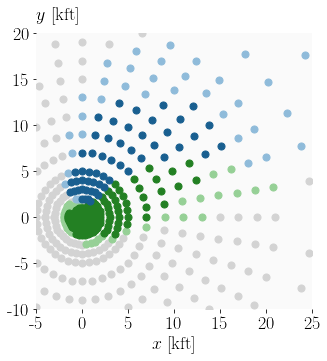

In [15]:
# Plot targets

fig, ax = plt.subplots(figsize=(5,5))

for label in range(5):
    if label == 0:  # COC clear of contact
        c = "lightgray"
    elif label == 1:  # Weak Left
        c = 1-(1-green)*0.5
    elif label == 3:  # Strong Left
        c = green*0.8
    elif label == 2:  # Weak Right
        c = 1-(1-blue)*0.5
    elif label == 4:  # Strong Right
        c = blue*0.8
    ax.scatter(X_filtered[z_filtered == label][:,0], X_filtered[z_filtered == label][:,1], color=c, s=50)

ax.set_xlim([(x_min),(x_max)])
plt.ylabel(r"$y$ [kft]",rotation=0 , fontsize=fontsize,ha="left")
ax.yaxis.set_label_coords(0.0, 1.03)
plt.xlabel(r"$x$ [kft]", fontsize=fontsize)
plt.ylim([(y_min),(y_max)])
plt.yticks(np.arange((y_min),(y_max)+0.001,5000),[f"{x:.0f}" for x in np.arange(y_min/1000,y_max/1000+0.001,5)])
plt.xticks(np.arange((x_min),(x_max)+0.001,5000),[f"{x:.0f}" for x in np.arange(x_min/1000,x_max/1000+0.001,5)])

ax.set_facecolor( (0.98, 0.98, 0.98) )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
fig.tight_layout()
ax.set_aspect('equal', 'box')


# fig.savefig(os.path.join(figure_path,"HCAS_tab_slice_gb.eps"), bbox_inches="tight")
# fig.savefig(os.path.join(figure_path,"HCAS_tab_slice_gb.png"), bbox_inches="tight")